In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    if np.isnan(L1):
        return np.inf
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    if np.isnan(L2):
        return np.inf
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    if np.isnan(L2):
        return np.inf
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    e = np.sum((np.abs((zr-np.real(ztot))))/(np.abs(zmag))) + \
        np.sum((np.abs((zj-np.abs(np.imag(ztot)))))/(np.abs(zmag)))

    L1 = e / n
    if np.isnan(L1):
        return np.inf
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr_l1, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(zr, zj, 'xk', label='Test Data')
    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zj, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$-Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr_l1, 'o-', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's-', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<-', label="Kaitlynn's norm")
    plt.plot(f, zr, 'xk', label='Test Data')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
    
    # residual plots
    plt.figure()
    plt.title(title)
    plt.plot(f, (zj-zj_l1)/zj, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zj-zj_l2)/zj, 's-', label='Log10 L2 norm')
    plt.plot(f, (zj-zj_linf)/zj, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zj-zj_lk)/zj, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j_resid.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, (zr-zr_l1)/zr, 'o-', label='Log10 L1 norm')
    plt.plot(f, (zr-zr_l2)/zr, 's-', label='Log10 L2 norm')
    plt.plot(f, (zr-zr_linf)/zr, '>-', label=r"L1 Kaitlynn's norm")
    plt.plot(f, (zr-zr_lk)/zr, '<-', label="Kaitlynn's norm")
    plt.plot([f[0], f[-1]], [0.0, 0.0], '-k')
    plt.xlabel(r'$f$')
    plt.ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')
    plt.xscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'r_resid.png', dpi=300, bbox_inches='tight')
    plt.show()

    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x

    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()

    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
    solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
                             limits=bounds, minimize=True)
#     solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
#                         limits=bounds, minimize=True)
#     solver.c = np.random.random()
#     solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')

    # res_bfgs = fmin_l_bfgs_b(obj_function, best, fprime=None, args=(),
    #                          approx_grad=True, bounds=bounds, m=10,
    #                          factr=10000000.0, pgtol=1e-05, epsilon=1e-05,
    #                          iprint=-1, maxfun=100000, maxiter=15000,
    #                          disp=None, callback=None, maxls=100)
    # if polish better save polish results
    # print(fit, res_bfgs[1])
    # if res_bfgs[1] < fit:
    #     opts = res_bfgs[1]
    #     results_x = res_bfgs[0]
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    #     print('Polish did not help')

    # res_slsqp = fmin_slsqp(obj_function, best, bounds=bounds, iter=1e10,
    #                        acc=1e-15, iprint=0, disp=None, full_output=1,
    #                        epsilon=1.4901161193847656e-08, callback=None)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if res_slsqp[1] < fit:
    #     opts = res_slsqp[1]
    #     results_x = res_slsqp[0]
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best

    # res_ls = least_squares(otto_model_L2_Kait_vec, best, bounds=bounds.T, method='trf', ftol=1e-15, xtol=1e-15, gtol=1e-15, loss='linear')
    # # print(res_ls)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if 2.0*res_ls.cost < fit:
    #     opts = res_ls.cost*2.0
    #     results_x = res_ls.x
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    
    # res_tr = minimize(obj_function, best, method='trust-constr', bounds=bounds, tol=None, callback=None, options={'grad': None, 'xtol': 1e-15, 'gtol': 1e-15, 'barrier_tol': 1e-08, 'sparse_jacobian': None, 'maxiter': 1e10, 'verbose': 0, 'finite_diff_rel_step': None, 'initial_constr_penalty': 1.0, 'initial_tr_radius': 1.0, 'initial_barrier_parameter': 0.1, 'initial_barrier_tolerance': 0.1, 'factorization_method': None, 'disp': False})
    # # print(res_ls)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if res_tr.cost < fit:
    #     opts = res_tr.cost
    #     results_x = res_tr.x
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=8):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
#     print('Paramters:', results_x)
#     print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Best Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


# Optimization on artifical solution
Run the optimization on known paramter values

Optimization runtime 85.7097 seconds
Best Objective value: 3.123835234930539e-11
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 8.34277308e+29
 8.90002532e+01] 



Optimization runtime 72.9321 seconds
Best Objective value: 1.029152073280649e-10
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 8.66072162e+29
 8.90000961e+01] 



Optimization runtime 76.2112 seconds
Best Objective value: 7.384386005579461e-14
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 8.99497112e+29
 8.90002876e+01] 



Optimization runtime 69.0192 seconds
Best Objective value: 6.534428316906643e-39
Best Paramters: [6.80000000e-01 8.80000000e+00 3.40000000e+01 1.50546533e+29
 8.90001881e+01] 





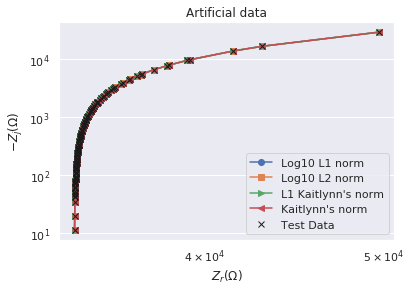

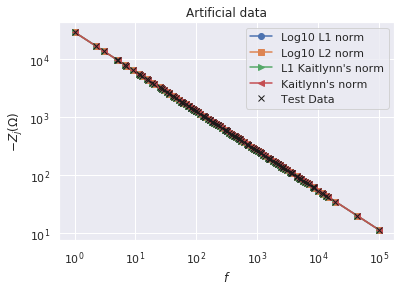

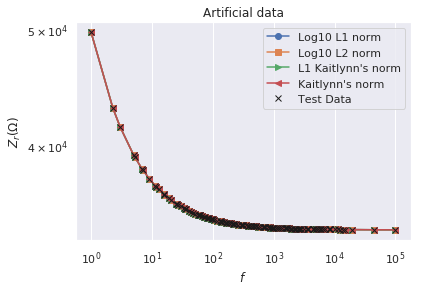

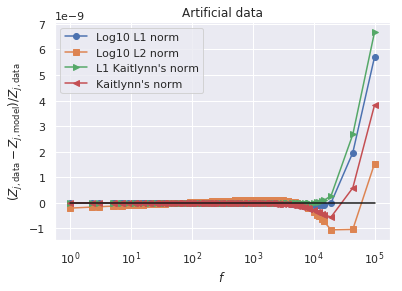

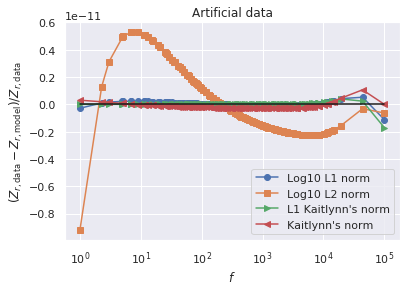

In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

dataset = pd.read_csv(data_prefix+data_list[0])
f = dataset.values[:, 0]
# sort the f values
f_ind = np.argsort(f)
f = f[f_ind]
n = len(f)


# generate fake results
zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])

# remove nans in zr and zj experimental data
inds = np.where(np.isnan(np.log10(zj)))
zj = np.delete(zj, inds)
zr = np.delete(zr, inds)
f = np.delete(f, inds)
n = len(f)

# run log10 optimizations
xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

# run normal optimizations
xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
     'Artificial data')

# Run optimization on Blue Test Data

Optimization runtime 83.4234 seconds
Best Objective value: 0.01833403085482497
Best Paramters: [3.96615696e-01 6.32998356e-01 1.71533368e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 75.3357 seconds
Best Objective value: 0.02725513285904579
Best Paramters: [4.04297673e-01 6.07266761e-01 2.66768678e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 78.6577 seconds
Best Objective value: 0.02840420684532863
Best Paramters: [3.95822271e-01 6.36244021e-01 1.63511265e+00 1.00000000e-04
 1.20889216e-10] 



Optimization runtime 71.6190 seconds
Best Objective value: 1214817349.7816398
Best Paramters: [4.75517822e-01 4.93265630e-01 2.05974466e+00 5.26564915e+29
 4.51950257e-04] 





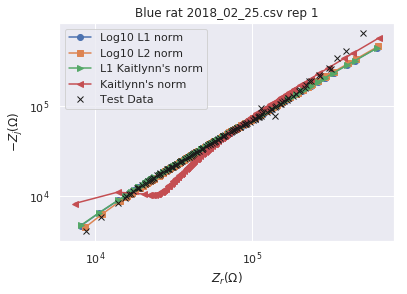

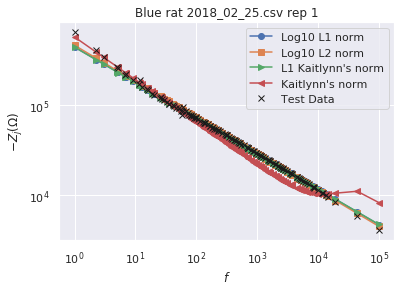

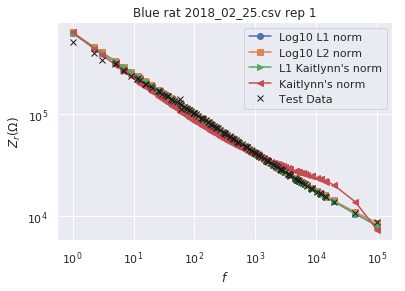

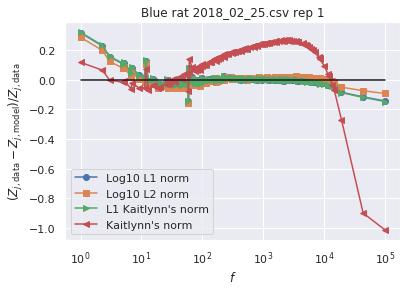

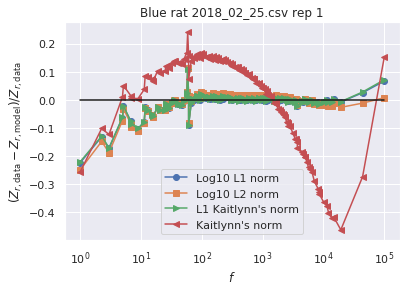

Optimization runtime 86.2787 seconds
Best Objective value: 0.01678008512439233
Best Paramters: [3.92039529e-01 6.38104269e-01 2.01609895e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 78.0849 seconds
Best Objective value: 0.02951913986592371
Best Paramters: [4.00011368e-01 6.10413393e-01 2.81376345e+00 6.47630016e+29
 3.62259290e-02] 



Optimization runtime 79.7458 seconds
Best Objective value: 0.025855874032905804
Best Paramters: [3.91127733e-01 6.42557466e-01 1.94153469e+00 1.00000000e-04
 1.00000000e-10] 



Optimization runtime 72.2001 seconds
Best Objective value: 2286608461.483964
Best Paramters: [4.89461232e-01 4.69242462e-01 1.59868500e+00 5.63362898e+29
 3.54131964e-04] 





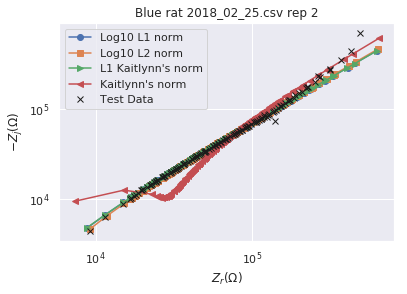

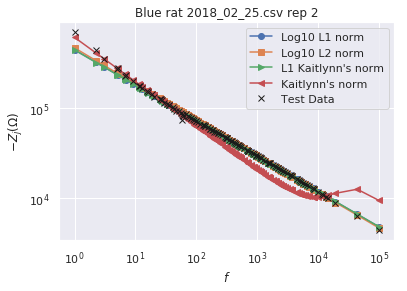

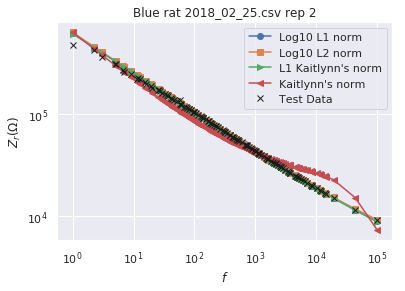

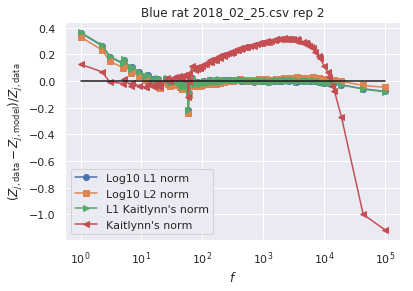

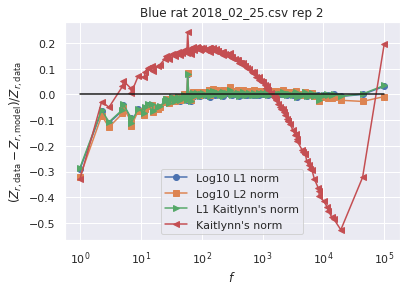

Optimization runtime 102.7676 seconds
Best Objective value: 0.06997536017626083
Best Paramters: [4.33003264e-01 5.51412906e-01 1.31134514e+01 1.00000000e+30
 1.28123651e-03] 



Optimization runtime 94.1441 seconds
Best Objective value: 0.11365234174759117
Best Paramters: [4.82237454e-01 3.91932079e-01 1.22766966e+01 9.99999637e+29
 6.36994802e-04] 



Optimization runtime 88.7326 seconds
Best Objective value: 0.08923747412578574
Best Paramters: [4.27024679e-01 5.75182145e-01 1.35095286e+01 8.56196115e+29
 1.53602384e-03] 



Optimization runtime 85.9277 seconds
Best Objective value: 757295423306.713
Best Paramters: [5.29345940e-01 2.94483900e-01 1.04427512e+01 3.93772212e+29
 2.62518032e-04] 





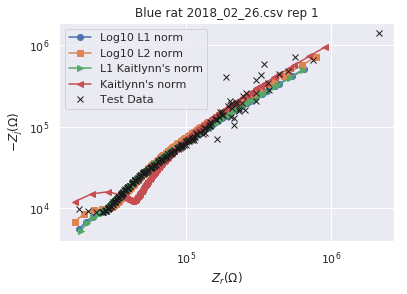

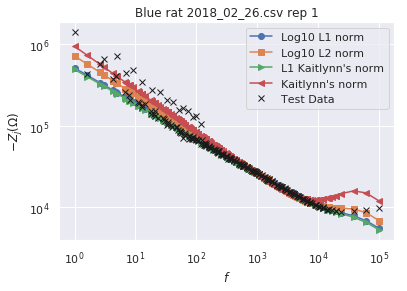

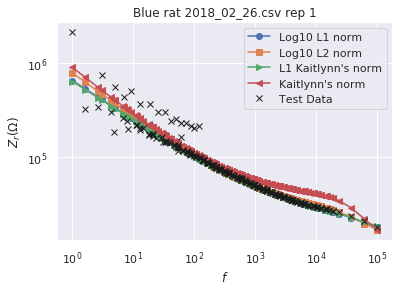

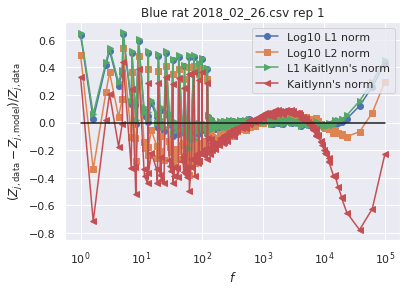

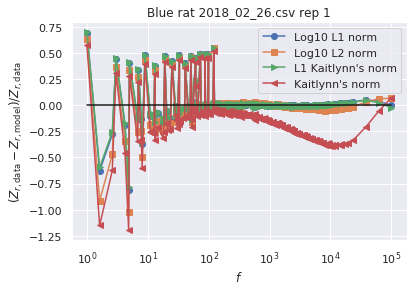

Optimization runtime 100.8109 seconds
Best Objective value: 0.06997536017626083
Best Paramters: [4.33003264e-01 5.51412906e-01 1.31134514e+01 8.24771287e+29
 1.28123651e-03] 



Optimization runtime 94.2405 seconds
Best Objective value: 0.11365234174759119
Best Paramters: [4.82237455e-01 3.91932077e-01 1.22766966e+01 1.00000000e+30
 6.36994793e-04] 



Optimization runtime 93.8972 seconds
Best Objective value: 0.08923747412578574
Best Paramters: [4.27024679e-01 5.75182145e-01 1.35095286e+01 4.94335936e+29
 1.53602384e-03] 



Optimization runtime 83.2046 seconds
Best Objective value: 757295423306.713
Best Paramters: [5.29345943e-01 2.94483898e-01 1.04427485e+01 8.32197484e+29
 2.62517970e-04] 





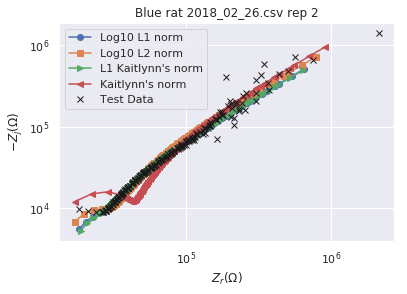

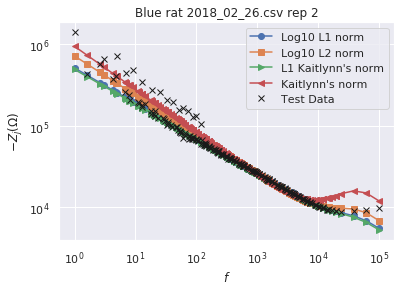

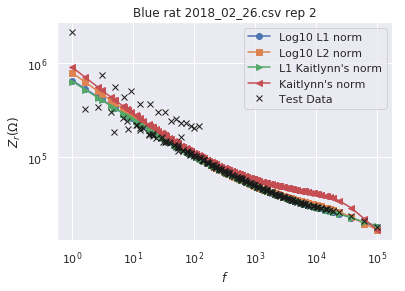

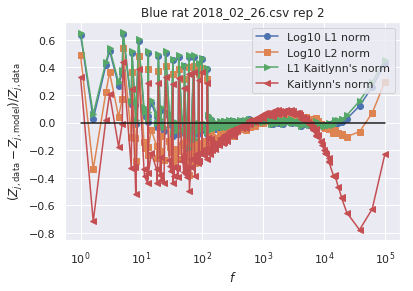

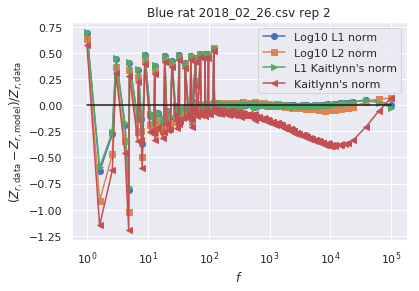

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10


Optimization runtime 103.4533 seconds
Best Objective value: 0.17724340242096737
Best Paramters: [7.01586100e-01 8.18264322e-03 1.00000000e-02 9.11848239e+29
 1.04989900e-04] 



Optimization runtime 88.9059 seconds
Best Objective value: 0.22069063812262055
Best Paramters: [5.84869471e-01 1.95322975e-02 1.00000000e-02 6.04781646e+29
 2.92112804e-04] 



Optimization runtime 89.1273 seconds
Best Objective value: 0.31891878840629817
Best Paramters: [6.13965940e-01 1.64824788e-02 1.00000000e-02 1.00000000e+30
 1.81996459e-04] 



Optimization runtime 83.5599 seconds
Best Objective value: 107042802736615.23
Best Paramters: [3.47937430e-01 8.67340338e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





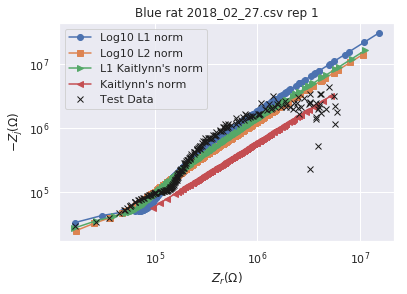

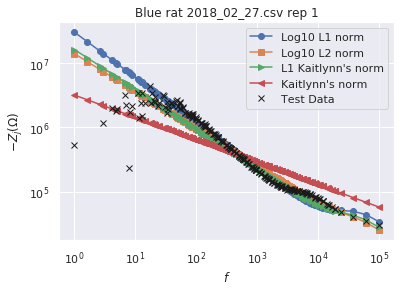

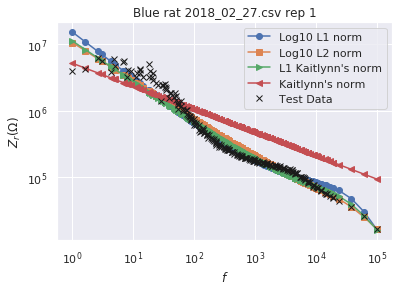

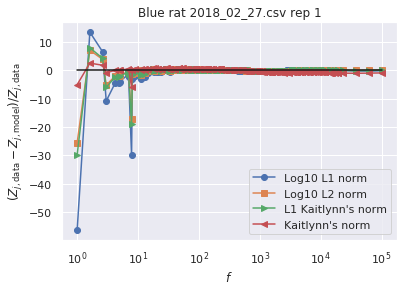

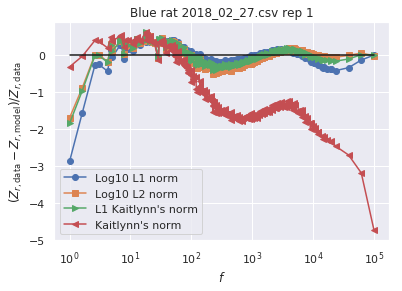

Optimization runtime 96.6056 seconds
Best Objective value: 0.18707263633172505
Best Paramters: [7.02409121e-01 8.01561798e-03 1.00000000e-02 2.42205743e+29
 1.05181549e-04] 



Optimization runtime 87.7002 seconds
Best Objective value: 0.2409737884013879
Best Paramters: [5.63278310e-01 2.26749883e-02 1.00000000e-02 1.97518517e+28
 4.58275895e-04] 



Optimization runtime 87.5778 seconds
Best Objective value: 0.3180390119528857
Best Paramters: [6.30654548e-01 1.41623415e-02 1.00000000e-02 1.00000000e+30
 1.63404984e-04] 



Optimization runtime 84.8310 seconds
Best Objective value: 155746528370227.88
Best Paramters: [3.63888623e-01 6.95133104e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





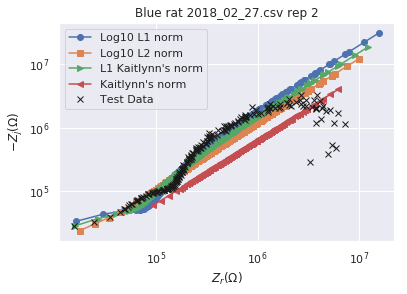

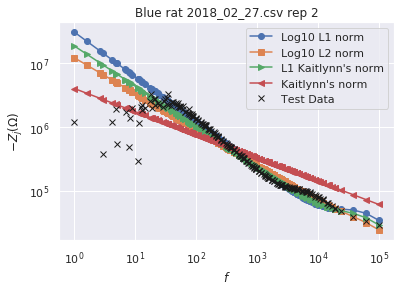

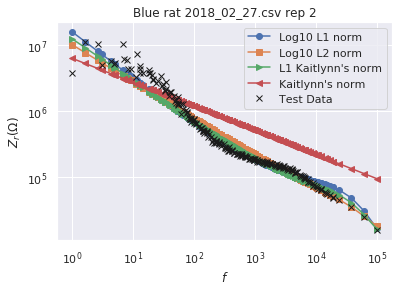

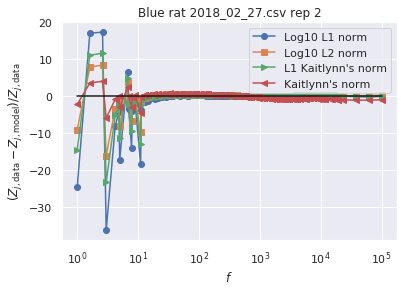

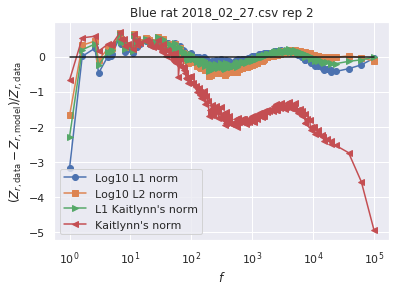

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10


Optimization runtime 98.0589 seconds
Best Objective value: 0.16757145815974483
Best Paramters: [7.07653769e-01 6.71601841e-03 1.00000000e-02 6.34709663e+29
 2.97774369e-04] 



Optimization runtime 82.7289 seconds
Best Objective value: 0.24344536285553767
Best Paramters: [7.37338632e-01 5.65694720e-03 1.00000000e-02 9.97140983e+29
 2.32952161e-04] 



Optimization runtime 85.7729 seconds
Best Objective value: 0.7561602671956411
Best Paramters: [5.10241845e-01 4.95683452e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 



Optimization runtime 81.1753 seconds
Best Objective value: 2115046556200227.8
Best Paramters: [3.58612517e-01 5.87762146e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





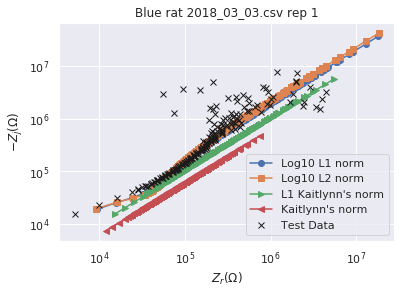

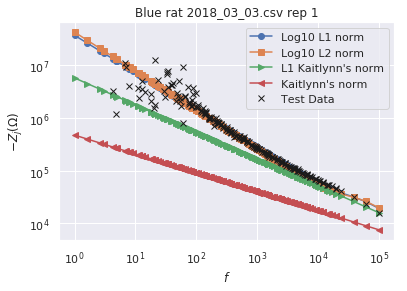

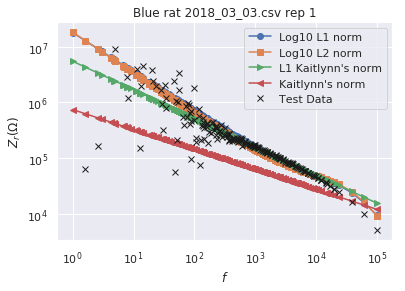

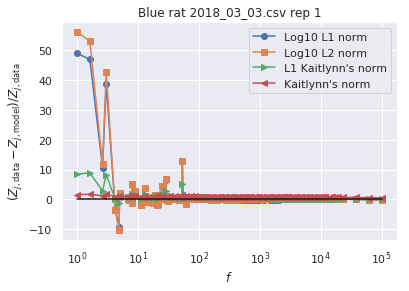

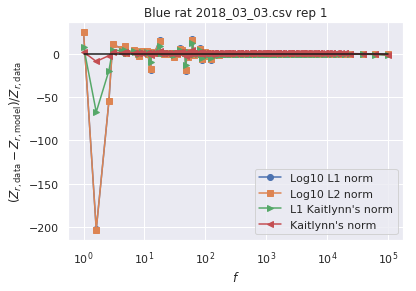

Optimization runtime 100.0790 seconds
Best Objective value: 0.1701348069676299
Best Paramters: [7.03555673e-01 6.94834013e-03 1.00000000e-02 8.90743793e+29
 2.87713932e-04] 



Optimization runtime 92.2596 seconds
Best Objective value: 0.2122802213627666
Best Paramters: [7.15573567e-01 6.33375399e-03 1.00000000e-02 9.77819143e+29
 3.01619389e-04] 



Optimization runtime 88.3629 seconds
Best Objective value: 0.6478896903175031
Best Paramters: [5.60691486e-01 2.72856660e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 



Optimization runtime 79.3773 seconds
Best Objective value: 1464275157789151.0
Best Paramters: [2.66826117e-01 3.43792609e-01 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





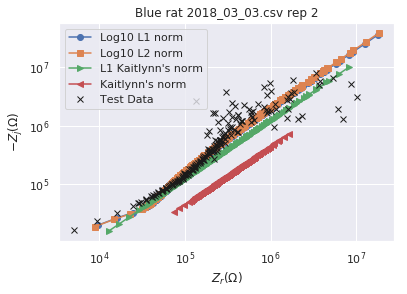

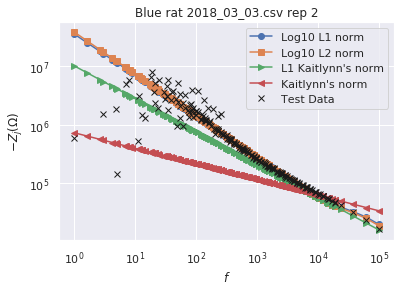

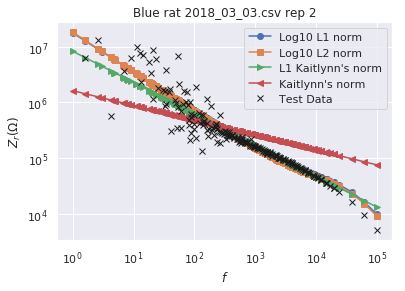

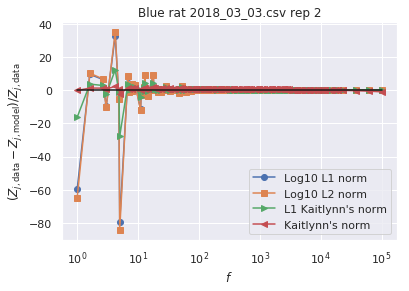

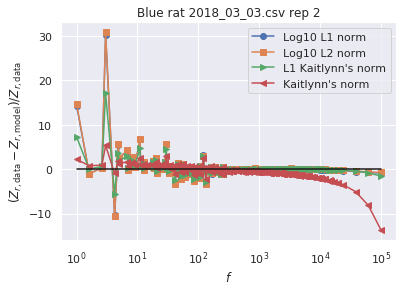

Optimization runtime 92.2878 seconds
Best Objective value: 0.09451909805222289
Best Paramters: [4.94898983e-01 4.52496557e-02 1.00000000e-02 1.00000000e+30
 7.50143922e-04] 



Optimization runtime 89.5171 seconds
Best Objective value: 0.117796176504357
Best Paramters: [5.12346276e-01 3.73739849e-02 1.00000000e-02 7.99064436e+29
 1.00000000e+03] 



Optimization runtime 89.9483 seconds
Best Objective value: 0.14583001152684516
Best Paramters: [4.92463800e-01 4.62074248e-02 1.00000000e-02 5.80393545e+29
 1.02706636e-03] 



Optimization runtime 82.0515 seconds
Best Objective value: 143765222906.04684
Best Paramters: [5.43016387e-01 2.90147388e-02 1.00000000e-02 6.64893412e+29
 8.73476807e-04] 





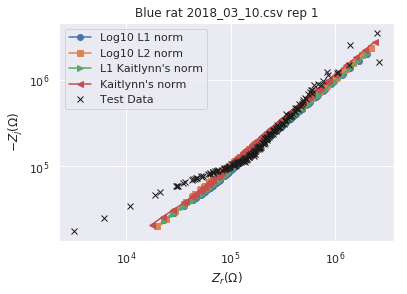

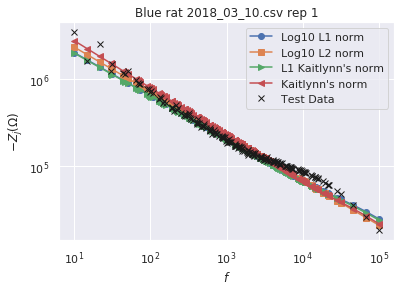

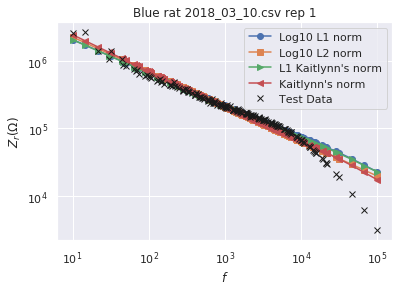

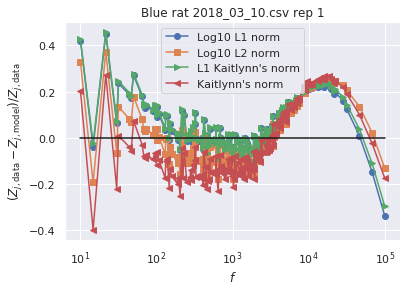

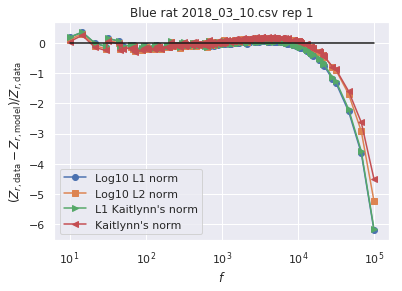

Optimization runtime 94.3789 seconds
Best Objective value: 0.10450323165062034
Best Paramters: [4.92826308e-01 4.68223568e-02 1.00000000e-02 6.26872436e+29
 6.25376133e-04] 



Optimization runtime 87.9600 seconds
Best Objective value: 0.12327942320336946
Best Paramters: [5.07207165e-01 3.95882061e-02 1.00000000e-02 1.00000000e+30
 1.42395651e-02] 



Optimization runtime 85.8678 seconds
Best Objective value: 0.16112739128350637
Best Paramters: [5.00643181e-01 4.45963476e-02 1.00000000e-02 9.74908399e+29
 5.20045285e-04] 



Optimization runtime 76.9598 seconds
Best Objective value: 362035176799.0194
Best Paramters: [4.95694966e-01 3.90781869e-02 1.00000000e-02 1.00000000e-04
 1.00000000e+03] 





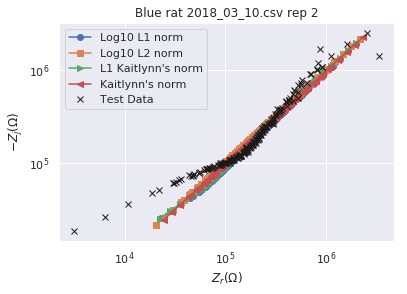

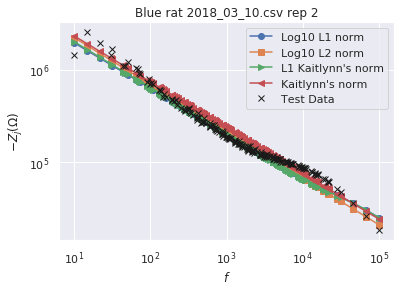

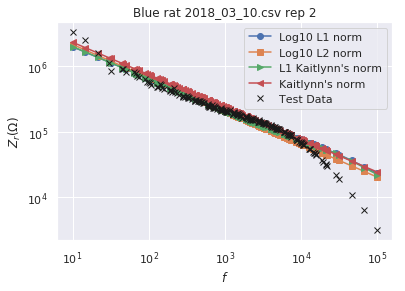

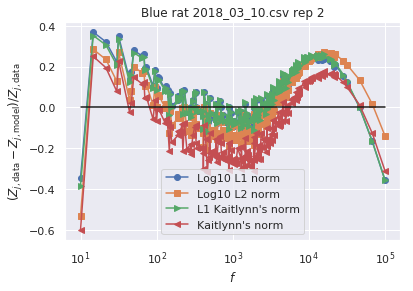

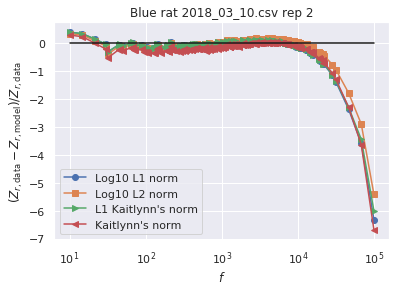

Stored 'res_l1' (ndarray)
Stored 'res_l2' (ndarray)
Stored 'res_lk1' (ndarray)
Stored 'res_lk2' (ndarray)
Stored 'l1_params' (list)
Stored 'l1_opts' (list)
Stored 'l2_params' (list)
Stored 'l2_opts' (list)
Stored 'lk1_params' (list)
Stored 'lk1_opts' (list)
Stored 'lk2_params' (list)
Stored 'lk2_opts' (list)


In [3]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

l1_params = []
l1_opts = []
l2_params = []
l2_opts = []
lk1_params = []
lk1_opts = []
lk2_params = []
lk2_opts = []

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        
        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # remove nans in zr and zj experimental data
        inds = np.where(np.isnan(np.log10(zj)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        inds = np.where(np.isnan(np.log10(zr)))
        zj = np.delete(zj, inds)
        zr = np.delete(zr, inds)
        f = np.delete(f, inds)
        n = len(f)

        # run log10 optimizations
        xs_l1, opts_l1, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        xs_l2, opts_l2, x_l2, opt_l2 = opt_routine(otto_model_L2_log)

        # reset data values
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]

        # sort the zr zj and f values
        f_ind = np.argsort(f)
        f = f[f_ind]
        zr = zr[f_ind]
        zj = zj[f_ind]

        # run normal optimizations
        xs_lk1, opts_lk1, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        xs_lk2, opts_lk2, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)

        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2
        
        # append results
        l1_params.append(xs_l1)
        l1_opts.append(opts_l1)
        l2_params.append(xs_l2)
        l2_opts.append(opts_l2)
        lk1_params.append(xs_lk1)
        lk1_opts.append(opts_lk1)
        lk2_params.append(xs_lk2)
        lk2_opts.append(opts_lk2)
        
        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
             'Blue rat ' + data + ' rep ' + str(i+1))

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2
%store l1_params
%store l1_opts
%store l2_params
%store l2_opts
%store lk1_params
%store lk1_opts
%store lk2_params
%store lk2_opts

# Example results for just one curve

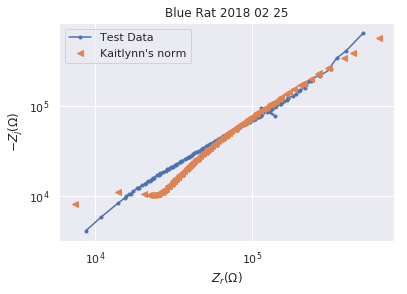

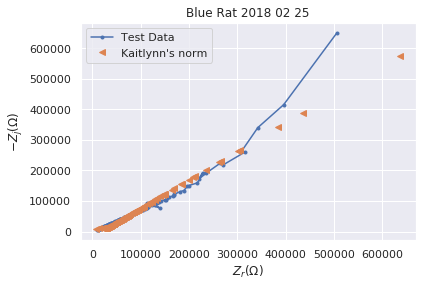

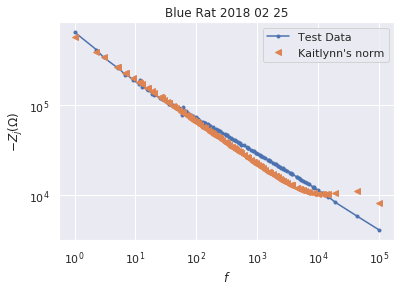

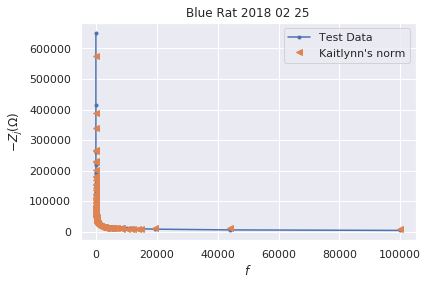

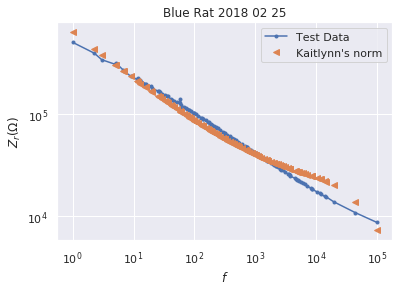

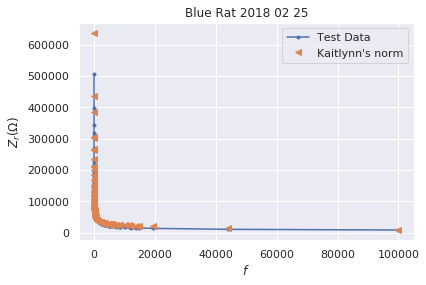

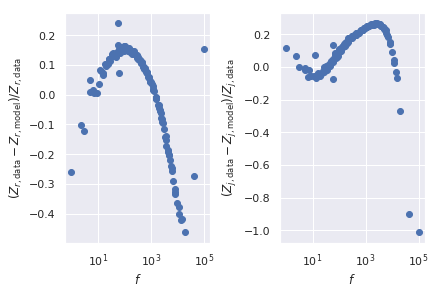

In [4]:
# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

# plot Kaitlynn's norm results
dataset = pd.read_csv(data_prefix+data_list[0])
j = 0*3
f = dataset.values[:, j]
n = len(f)
zr = dataset.values[:, j+1]
zj = dataset.values[:, j+2]
zr_lk, zj_lk = otto_model_create_data(res_lk2[0, :5])
title = 'Blue Rat 2018 02 25'
plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logrj.png', dpi=300, bbox_inches='tight')


plt.figure()
plt.title(title)
plt.plot(zr, zj, '.-', label='Test Data')
plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

plt.xlabel(r'$Z_r (\Omega)$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logj.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zj, '.-', label='Test Data')
plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$-Z_j (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('figs/' + title + 'logr.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title(title)
plt.plot(f, zr, '.-', label='Test Data')
plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
plt.xlabel(r'$f$')
plt.ylabel(r'$Z_r (\Omega)$')
plt.legend()
plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')
plt.show()

# new plots based on Kaitlynn's suggestion
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(f, (zr-zr_lk)/zr, 'o')
ax[0].set_xscale('log')
ax[0].set_xlabel('$f$')
ax[0].set_ylabel(r'$(Z_{r,\mathrm{data}} - Z_{r,\mathrm{model}})/Z_{r,\mathrm{data}}$')

ax[1].plot(f, (zj-zj_lk)/zj, 'o')
ax[1].set_xscale('log')
ax[1].set_xlabel('$f$')
ax[1].set_ylabel(r'$(Z_{j,\mathrm{data}} - Z_{j,\mathrm{model}})/Z_{j,\mathrm{data}}$')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [5]:
columns = ['alpha CPE phase factor','K CPE magnitude factor', 'ren encapsulation resistance', 'rex extracellular resistance', 'am membrane area in cm**2', 'objective value']
index_rows = ['blue rat 2018_02_25 rep 1', 'blue rat 2018_02_25 rep 2', 'blue rat 2018_02_26 rep 1', 'blue rat 2018_02_26 rep 2', 'blue rat 2018_02_27 rep 1', 'blue rat 2018_02_27 rep 2',
             'blue rat 2018_03_03 rep 1', 'blue rat 2018_03_03 rep 2', 'blue rat 2018_03_10 rep 1', 'blue rat 2018_03_10 rep 2']
pd_l1 = pd.DataFrame(res_l1, index=index_rows, columns=columns)
pd_l2 = pd.DataFrame(res_l2, index=index_rows, columns=columns)
pd_lk1 = pd.DataFrame(res_lk1, index=index_rows, columns=columns)
pd_lk2 = pd.DataFrame(res_lk2, index=index_rows, columns=columns)

# Log10 L1 Norm

In [6]:
pd_l1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.396616,0.632998,1.715334,1.000000e-04,1.000000e-10,0.018334
blue rat 2018_02_25 rep 2,0.392040,0.638104,2.016099,1.000000e-04,1.000000e-10,0.016780
blue rat 2018_02_26 rep 1,0.433003,0.551413,13.113451,1.000000e+30,1.281237e-03,0.069975
blue rat 2018_02_26 rep 2,0.433003,0.551413,13.113451,8.247713e+29,1.281237e-03,0.069975
blue rat 2018_02_27 rep 1,0.701586,0.008183,0.010000,9.118482e+29,1.049899e-04,0.177243
blue rat 2018_02_27 rep 2,0.702409,0.008016,0.010000,2.422057e+29,1.051815e-04,0.187073
blue rat 2018_03_03 rep 1,0.707654,0.006716,0.010000,6.347097e+29,2.977744e-04,0.167571
blue rat 2018_03_03 rep 2,0.703556,0.006948,0.010000,8.907438e+29,2.877139e-04,0.170135
blue rat 2018_03_10 rep 1,0.494899,0.045250,0.010000,1.000000e+30,7.501439e-04,0.094519
blue rat 2018_03_10 rep 2,0.492826,0.046822,0.010000,6.268724e+29,6.253761e-04,0.104503


# Log10 L2 Norm

In [7]:
pd_l2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.404298,0.607267,2.667687,1.000000e-04,1.000000e-10,0.027255
blue rat 2018_02_25 rep 2,0.400011,0.610413,2.813763,6.476300e+29,3.622593e-02,0.029519
blue rat 2018_02_26 rep 1,0.482237,0.391932,12.276697,9.999996e+29,6.369948e-04,0.113652
blue rat 2018_02_26 rep 2,0.482237,0.391932,12.276697,1.000000e+30,6.369948e-04,0.113652
blue rat 2018_02_27 rep 1,0.584869,0.019532,0.010000,6.047816e+29,2.921128e-04,0.220691
blue rat 2018_02_27 rep 2,0.563278,0.022675,0.010000,1.975185e+28,4.582759e-04,0.240974
blue rat 2018_03_03 rep 1,0.737339,0.005657,0.010000,9.971410e+29,2.329522e-04,0.243445
blue rat 2018_03_03 rep 2,0.715574,0.006334,0.010000,9.778191e+29,3.016194e-04,0.212280
blue rat 2018_03_10 rep 1,0.512346,0.037374,0.010000,7.990644e+29,1.000000e+03,0.117796
blue rat 2018_03_10 rep 2,0.507207,0.039588,0.010000,1.000000e+30,1.423957e-02,0.123279


# L1 Kaitlynn's Norm

In [8]:
pd_lk1

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.395822,0.636244,1.635113,1.000000e-04,1.208892e-10,0.028404
blue rat 2018_02_25 rep 2,0.391128,0.642557,1.941535,1.000000e-04,1.000000e-10,0.025856
blue rat 2018_02_26 rep 1,0.427025,0.575182,13.509529,8.561961e+29,1.536024e-03,0.089237
blue rat 2018_02_26 rep 2,0.427025,0.575182,13.509529,4.943359e+29,1.536024e-03,0.089237
blue rat 2018_02_27 rep 1,0.613966,0.016482,0.010000,1.000000e+30,1.819965e-04,0.318919
blue rat 2018_02_27 rep 2,0.630655,0.014162,0.010000,1.000000e+30,1.634050e-04,0.318039
blue rat 2018_03_03 rep 1,0.510242,0.049568,0.010000,1.000000e-04,1.000000e+03,0.756160
blue rat 2018_03_03 rep 2,0.560691,0.027286,0.010000,1.000000e-04,1.000000e+03,0.647890
blue rat 2018_03_10 rep 1,0.492464,0.046207,0.010000,5.803935e+29,1.027066e-03,0.145830
blue rat 2018_03_10 rep 2,0.500643,0.044596,0.010000,9.749084e+29,5.200453e-04,0.161127


# L2 Kaitlynn's (original) norm

In [9]:
pd_lk2

,alpha CPE phase factor,K CPE magnitude factor,ren encapsulation resistance,rex extracellular resistance,am membrane area in cm**2,objective value
blue rat 2018_02_25 rep 1,0.475518,0.493266,2.059745,5.265649e+29,0.000452,1.214817e+09
blue rat 2018_02_25 rep 2,0.489461,0.469242,1.598685,5.633629e+29,0.000354,2.286608e+09
blue rat 2018_02_26 rep 1,0.529346,0.294484,10.442751,3.937722e+29,0.000263,7.572954e+11
blue rat 2018_02_26 rep 2,0.529346,0.294484,10.442749,8.321975e+29,0.000263,7.572954e+11
blue rat 2018_02_27 rep 1,0.347937,0.086734,0.010000,1.000000e-04,1000.000000,1.070428e+14
blue rat 2018_02_27 rep 2,0.363889,0.069513,0.010000,1.000000e-04,1000.000000,1.557465e+14
blue rat 2018_03_03 rep 1,0.358613,0.587762,0.010000,1.000000e-04,1000.000000,2.115047e+15
blue rat 2018_03_03 rep 2,0.266826,0.343793,0.010000,1.000000e-04,1000.000000,1.464275e+15
blue rat 2018_03_10 rep 1,0.543016,0.029015,0.010000,6.648934e+29,0.000873,1.437652e+11
blue rat 2018_03_10 rep 2,0.495695,0.039078,0.010000,1.000000e-04,1000.000000,3.620352e+11
